# Project Benson Challenge

In [97]:
import pandas as pd
import os
import json
from pprint import pprint
from pandas import DataFrame, Series
import numpy as np
import math 

import matplotlib.pyplot as plt
%matplotlib inline

__Challenge 1__

In [42]:
# df=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180303.txt')
# df[df['STATION']=='59 ST'][100:200]
# df['DIVISION'].unique()
# df.groupby(['STATION'])[['UNIT','C/A']].count()
# pd.crosstab(df['STATION'], df['C/A'])[:100]
# df.columns=[column.strip().lower() for column in df.columns]
# df.columns.rename({column: column.strip().lower() for column in df.columns})
# df.columns

In [2]:
# dates = [303, 310, 317, 324, 331, 407, 414, 421, 428, 505, 512, 519, 526, 602]
# date_urls = ['http://web.mta.info/developers/data/nyct/turnstile/turnstile_180{}.txt'.format(date) for date in dates]
# df = pd.concat([pd.read_csv(url) for url in date_urls]).to_csv('origin.csv')

In [2]:
df = pd.read_csv('/Users/bellepeng/Desktop/Metis/sf18_ds11/challenges/challenges_data/mta.csv')
df.reset_index(drop=True).head()
df.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,03:00:00,RECOVR AUD,6527780,2210496
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,07:00:00,REGULAR,6527794,2210507
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,11:00:00,REGULAR,6527838,2210585
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,15:00:00,REGULAR,6527994,2210644
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,19:00:00,REGULAR,6528278,2210705


__Challenge 2__  
Let's turn this into a time series.  
For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries.  

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the dateutil module to convert it into a datetime object. For an example check this StackOverflow question.  

Your new dict should look something like  
  
{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ [datetime.datetime(2013, 3, 2, 3, 0), 3788], [datetime.datetime(2013, 3, 2, 7, 0), 2585], [datetime.datetime(2013, 3, 2, 12, 0), 10653], [datetime.datetime(2013, 3, 2, 17, 0), 11016], [datetime.datetime(2013, 3, 2, 23, 0), 10666], [datetime.datetime(2013, 3, 3, 3, 0), 10814], [datetime.datetime(2013, 3, 3, 7, 0), 10229], ... ], .... }

In [4]:
import datetime
from datetime import datetime as dt

In [5]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [6]:
# Take the date and time fields into a single datetime column
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,03:00:00,RECOVR AUD,6527780,2210496,2018-02-24 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,07:00:00,REGULAR,6527794,2210507,2018-02-24 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,11:00:00,REGULAR,6527838,2210585,2018-02-24 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,15:00:00,REGULAR,6527994,2210644,2018-02-24 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,19:00:00,REGULAR,6528278,2210705,2018-02-24 19:00:00


In [7]:
df_daily = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"]).ENTRIES.first().reset_index()
df_daily.head(5)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,02/24/2018,6527780
1,A002,R051,02-00-00,59 ST,02/25/2018,6528417
2,A002,R051,02-00-00,59 ST,02/26/2018,6528905
3,A002,R051,02-00-00,59 ST,02/27/2018,6530309
4,A002,R051,02-00-00,59 ST,02/28/2018,6531774


__Challenge 3__

These counts are for every __4__ hours. We want total daily entries.
Now make it that we again have the same keys, but now we have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day.

In [8]:
df_daily[["PREV_DATE", "PREV_ENTRIES"]] = \
    (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
            .transform(lambda grp: grp.shift(1)))

df_daily.tail(5)
df_daily.head(5)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,02/24/2018,6527780,NaN,NaN
1,A002,R051,02-00-00,59 ST,02/25/2018,6528417,02/24/2018,6527780.0
2,A002,R051,02-00-00,59 ST,02/26/2018,6528905,02/25/2018,6528417.0
3,A002,R051,02-00-00,59 ST,02/27/2018,6530309,02/26/2018,6528905.0
4,A002,R051,02-00-00,59 ST,02/28/2018,6531774,02/27/2018,6530309.0


In [9]:
# Drop the rows for last date
df_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
df_daily.head(5)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,02/25/2018,6528417,02/24/2018,6527780.0
2,A002,R051,02-00-00,59 ST,02/26/2018,6528905,02/25/2018,6528417.0
3,A002,R051,02-00-00,59 ST,02/27/2018,6530309,02/26/2018,6528905.0
4,A002,R051,02-00-00,59 ST,02/28/2018,6531774,02/27/2018,6530309.0
5,A002,R051,02-00-00,59 ST,03/01/2018,6533215,02/28/2018,6531774.0


In [10]:
# Strange data
df_daily[df_daily["ENTRIES"] < df_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
3310,A010,R080,00-00-07,57 ST-7 AV,05/11/2018,3239,05/10/2018,29161864.0
3333,A011,R080,01-00-00,57 ST-7 AV,02/25/2018,886134732,02/24/2018,886136967.0
3334,A011,R080,01-00-00,57 ST-7 AV,02/26/2018,886133005,02/25/2018,886134732.0
3335,A011,R080,01-00-00,57 ST-7 AV,02/27/2018,886129468,02/26/2018,886133005.0
3336,A011,R080,01-00-00,57 ST-7 AV,02/28/2018,886125746,02/27/2018,886129468.0


In [11]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
#         print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits

df_daily['DAILY_ENTRIES'] = df_daily.apply(get_daily_counts, axis=1, max_counter=1000000)
df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,02/25/2018,6528417,02/24/2018,6527780.0,637.0
2,A002,R051,02-00-00,59 ST,02/26/2018,6528905,02/25/2018,6528417.0,488.0
3,A002,R051,02-00-00,59 ST,02/27/2018,6530309,02/26/2018,6528905.0,1404.0
4,A002,R051,02-00-00,59 ST,02/28/2018,6531774,02/27/2018,6530309.0,1465.0
5,A002,R051,02-00-00,59 ST,03/01/2018,6533215,02/28/2018,6531774.0,1441.0


In [12]:
df_daily2 = df_daily.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"]).DAILY_ENTRIES.sum().reset_index()
df_daily2.head(5)

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
0,A002,R051,02-00-00,59 ST,02/25/2018,637.0
1,A002,R051,02-00-00,59 ST,02/26/2018,488.0
2,A002,R051,02-00-00,59 ST,02/27/2018,1404.0
3,A002,R051,02-00-00,59 ST,02/28/2018,1465.0
4,A002,R051,02-00-00,59 ST,03/01/2018,1441.0


__Challenge 4__

We will plot the daily time series for a turnstile.

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts. This should plot it:

In [13]:
df_daily2.sort_values(by=['DATE'], inplace=True)

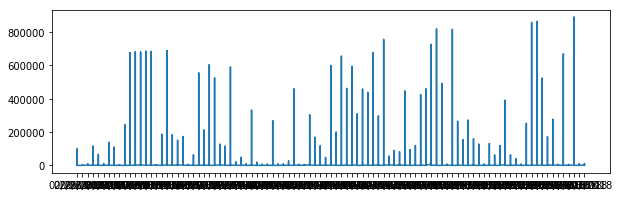

In [14]:
plt.figure(figsize=(10,3))
plt.plot(df_daily2['DATE'],df_daily2['DAILY_ENTRIES'])

__Challenge 5__

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.  

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.  

In [16]:
df_daily2 = df_daily.groupby(["C/A", "UNIT", "STATION", "DATE"]).DAILY_ENTRIES.sum().reset_index()

In [17]:
df_daily3 = df_daily.groupby(["C/A", "UNIT", "STATION", "DATE"]).DAILY_ENTRIES.sum().reset_index()
df_daily3.head(5)

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,02/25/2018,6859.0
1,A002,R051,59 ST,02/26/2018,4996.0
2,A002,R051,59 ST,02/27/2018,12483.0
3,A002,R051,59 ST,02/28/2018,13101.0
4,A002,R051,59 ST,03/01/2018,13119.0


In [19]:
df_daily4=df_daily.groupby(["C/A", "UNIT", "STATION"]).DAILY_ENTRIES.sum().reset_index()
df_daily4.head(5)
#The train stations names need to be cleaned up

,C/A,UNIT,STATION,DAILY_ENTRIES
0,A002,R051,59 ST,1053929.0
1,A006,R079,5 AV/59 ST,904052.0
2,A007,R079,5 AV/59 ST,385462.0
3,A010,R080,57 ST-7 AV,1795840.0
4,A011,R080,57 ST-7 AV,1349742.0


__Challenge 6__

Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [21]:
df_daily5=df_daily.groupby(["STATION", "DATE"]).DAILY_ENTRIES.sum().reset_index()
df_daily5.head(5)
#The train stations names need to be cleaned up

,STATION,DATE,DAILY_ENTRIES
0,1 AV,02/25/2018,18041.0
1,1 AV,02/26/2018,12293.0
2,1 AV,02/27/2018,21179.0
3,1 AV,02/28/2018,22096.0
4,1 AV,03/01/2018,86594.0


__Challenge 7__

Plot the time series for a station.

In [24]:
one_station=df_daily5.loc[df_daily5['STATION']=='1 AV']
one_station.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,02/25/2018,18041.0
1,1 AV,02/26/2018,12293.0
2,1 AV,02/27/2018,21179.0
3,1 AV,02/28/2018,22096.0
4,1 AV,03/01/2018,86594.0


In [25]:
one_station.sort_values(by=['DATE'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


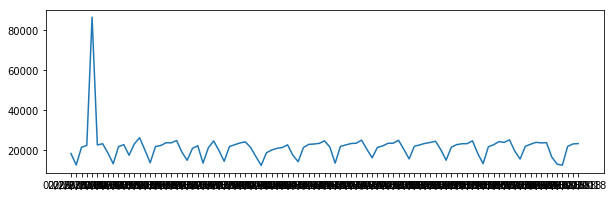

In [26]:
plt.figure(figsize=(10,3))
plt.plot(one_station['DATE'],one_station['DAILY_ENTRIES'])

__Challenge 8__

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [44]:
one_station['DATE'] = pd.to_datetime(one_station['DATE']) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [70]:
one_station['weekday']=one_station['DATE'].apply(dt.weekday)
one_station.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,STATION,DATE,DAILY_ENTRIES,weekday
0,1 AV,2018-02-25,18041.0,6
1,1 AV,2018-02-26,12293.0,0
2,1 AV,2018-02-27,21179.0,1
3,1 AV,2018-02-28,22096.0,2
4,1 AV,2018-03-01,86594.0,3


In [71]:
one_station.sort_values(by=['DATE', 'weekday'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
week_num=[]
for i in range(len(one_station)):
    week_num.append("week"+str(math.ceil((i+1)/7)))

week_num[:14]

['week1',
 'week1',
 'week1',
 'week1',
 'week1',
 'week1',
 'week1',
 'week2',
 'week2',
 'week2',
 'week2',
 'week2',
 'week2',
 'week2']

In [104]:
one_station['week_num']=week_num
one_station.head(20)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,STATION,DATE,DAILY_ENTRIES,weekday,week_num
0,1 AV,2018-02-25,18041.0,6,week1
1,1 AV,2018-02-26,12293.0,0,week1
2,1 AV,2018-02-27,21179.0,1,week1
3,1 AV,2018-02-28,22096.0,2,week1
4,1 AV,2018-03-01,86594.0,3,week1
5,1 AV,2018-03-02,22342.0,4,week1
6,1 AV,2018-03-03,22952.0,5,week1
7,1 AV,2018-03-04,18310.0,6,week2
8,1 AV,2018-03-05,12902.0,0,week2
9,1 AV,2018-03-06,21506.0,1,week2


In [103]:
weekly=one_station.groupby(['week_num', 'weekday'])['DAILY_ENTRIES'].sum().reset_index()
weekly.head(10)

,week_num,weekday,DAILY_ENTRIES
0,week1,0,12293.0
1,week1,1,21179.0
2,week1,2,22096.0
3,week1,3,86594.0
4,week1,4,22342.0
5,week1,5,22952.0
6,week1,6,18041.0
7,week10,0,15331.0
8,week10,1,21710.0
9,week10,2,22367.0


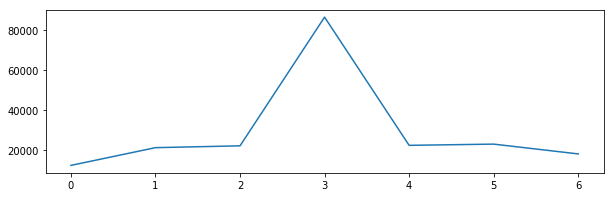

In [114]:
test=weekly[:7].sort_values(by=['weekday'])
plt.figure(figsize=(10,3))
plt.plot(test['weekday'],test['DAILY_ENTRIES'])

In [106]:
weekly.sort_values(by=['weekday'], inplace=True)

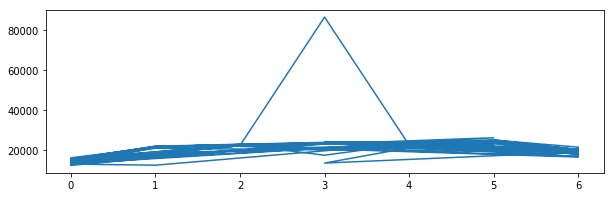

In [109]:
plt.figure(figsize=(10,3))
plt.plot(weekly['weekday'],weekly['DAILY_ENTRIES'])

__Challenge 9__

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

__Challenge 10__

Make a single list of these total ridership values and plot it with

plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among different stations.

This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

Additional Hint:

If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a plt.bar graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be 0,1,2,3,..., so you can do

indices = range(len(total_ridership_values))
plt.bar(indices, total_ridership_values)